In [1]:
##%matplotlib widget
## with %matplotlib notebook: seems to require ipympl as part of environment, either
## part of the conda environment or "pip install ipympl"
## otherwise, does not show ANY plots in notebook, plt.savefig() works
%matplotlib notebook  
##%matplotlib inline    ## --plt.savefig()  works, but re-sizing does NOT

Check the current GPU usage. Please try to be nice!

In [2]:
!nvidia-smi

Sat Mar  6 12:20:32 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 440.64.00    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN V             Off  | 00000000:03:00.0 Off |                  N/A |
| 26%   31C    P0    31W / 250W |      0MiB / 12066MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P100-PCIE...  Off  | 00000000:83:00.0 Off |                    0 |
| N/A   32C    P0    33W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

## Imports

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
import pandas as pd
import mlflow

# Python 3 standard library
from pathlib import Path

from torchsummary import summary

'''
HELPER FUNCTIONS
'''
# From model/collectdata.py
from model.collectdata_mdsA import collect_data
# For poca KDE
from model.collectdata_poca_KDE import collect_data_poca

# From model/loss.py
##from loss import Loss
from model.alt_loss_A import Loss

# From model/training.py
from model.training import trainNet, select_gpu, Results

# From model/models.py
##  will start with model from TwoFeatures_CNN6Layer_A in the first instance
##  see relevant cell below

from model.models_mjp_19November20 import SimpleCNN5Layer_Ca_A as ModelA
from model.models_mjp_19November20 import SimpleCNN5Layer_Ca_E as ModelE
from model.models_mjp_19November20 import SimpleCNN7Layer_Ca_W as ModelW
from model.models_mjp_26December20 import SimpleCNN9Layer_Ca_X as ModelX
from model.models_mjp_26December20 import SimpleCNN7Layer_Ca_Y as ModelY
from model.models_mjp_30Jan21_AllCNN import ACN_1_10L_4S as ModelXX

# From model/utilities.py
from model.utilities import load_full_state, count_parameters, Params

from model.plots import dual_train_plots, replace_in_ax

## adds image of model architecture
import hiddenlayer as HL

/data/conda/envs/goofit-june2020/lib/python3.7/site-packages/awkward/__init__.py:23: DeprecationWarning: Consider switching from 'awkward' to 'awkward1', since the new interface will become the default later this year (2020).

    pip install -U awkward1

In Python:

    >>> import awkward1 as ak
    >>> new_style_array = ak.from_awkward0(old_style_array)
    >>> old_style_array = ak.to_awkward0(new_style_array)

  DeprecationWarning


Set up Torch device configuration. All tensors and model parameters need to know where to be put.
This takes a BUS ID number: The BUS ID is the same as the listing at the top of this script.

In [4]:
device = select_gpu(0)

1 available GPUs (initially using device 0):
  0 TITAN V


/data/conda/envs/goofit-june2020/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Set up local parameters

In [5]:
# params order - batch size, epochs, lr, epoch_start (which is usually set to 0)
args = Params(128, 200, 1e-4, 20)

## Loading data

Load the dataset, split into parts, then move to device (see `collectdata.py` in the `../model` directory)

In [6]:
## newer vernacular
## Training dataset. You can put as many files here as desired.

## This is used when training with the original KDE
'''
## in this DEMO example we use only one 80K training set -- the model starts with well-trained weights,
## and using a smaller training set reduces both the time to load the data and the time to train an epoch
##  set the option load_XandXsq = True to use both DKE and KDE^2 as input features
train_loader = collect_data('/share/lazy/sokoloff/ML-data_A/Aug14_80K_train.h5',
                             '/share/lazy/sokoloff/ML-data_AA/Oct03_80K_train.h5',
#                             '/share/lazy/sokoloff/ML-data_AA/Oct03_40K_train.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_1.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_3.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_4.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_5.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_6.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_7.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_8.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_9.h5',
                            #'/share/lazy/sokoloff/ML-data_AA/Oct03_80K2_train.h5',
                             batch_size=args.batch_size,
## if we are using a larger dataset (240K events, with the datasets above, and 11 GB  of GPU memory),
## not the dataset will overflow the GPU memory; device=device will allow the data to move back
## and forth between the CPU and GPU memory. While this allows use of a larger dataset, it slows
## down performance by about 10%.  So comment out when not needed.
                            device=device,
                            masking=True, shuffle=True,
                            load_XandXsq=False,
                            load_xy=False)

# Validation dataset. You can slice to reduce the size.
## dataAA -> /share/lazy/sokoloff/ML-data_AA/
val_loader = collect_data('/share/lazy/sokoloff/ML-data_AA/Oct03_20K_val.h5',
## mds val_loader = collect_data('dataAA/HLT1CPU_1kevts_val.h5',

                          batch_size=args.batch_size,
                          slice=slice(256 * 39),
                          device=device,
                          masking=True, shuffle=False,
                          load_XandXsq=False,
                          load_xy=False)
'''

## This is used when training with the new KDE
train_loader = collect_data_poca('/share/lazy/will/data/June30_2020_80k_1.h5',
                            '/share/lazy/will/data/June30_2020_80k_3.h5',
                            batch_size=args.batch_size,
                            device=device,
                            masking=True, shuffle=True,
                           ## slice = slice(0,18000)
                           )

val_loader = collect_data_poca('/share/lazy/sokoloff/ML-data_AA/20K_POCA_kernel_evts_200926.h5',
                            batch_size=args.batch_size,
                            device=device,
                            masking=True, shuffle=True,
                            ##slice = slice(18000,None)
                           )

Loading data...
Loaded /share/lazy/will/data/June30_2020_80k_1.h5 in 13.4 s
Loaded /share/lazy/will/data/June30_2020_80k_3.h5 in 13.59 s
Constructing 160000 event dataset took 4.941 s
Loading data...
Loaded /share/lazy/sokoloff/ML-data_AA/20K_POCA_kernel_evts_200926.h5 in 3.232 s
Constructing 20000 event dataset took 0.1214 s


# Preparing the model

Prepare a model, use multiple GPUs if they are VISIBLE, and move the model to the device.

In [7]:
model = ModelXX()

##summary(model, input_size=(4, 4000))
##print(model.parameters)

mlflow.tracking.set_tracking_uri('file:/share/lazy/pv-finder_model_repo')
mlflow.set_experiment('Four Feature AllCNN')

Traceback (most recent call last):
  File "/home/michael24peters/.local/lib/python3.7/site-packages/mlflow/store/tracking/file_store.py", line 197, in list_experiments
    experiment = self._get_experiment(exp_id, view_type)
  File "/home/michael24peters/.local/lib/python3.7/site-packages/mlflow/store/tracking/file_store.py", line 260, in _get_experiment
    meta = read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
  File "/home/michael24peters/.local/lib/python3.7/site-packages/mlflow/utils/file_utils.py", line 167, in read_yaml
    raise MissingConfigException("Yaml file '%s' does not exist." % file_path)
mlflow.exceptions.MissingConfigException: Yaml file '/share/lazy/pv-finder_model_repo/ML/meta.yaml' does not exist.


In [8]:
print("Let's use", torch.cuda.device_count(), "GPUs!")
if torch.cuda.device_count() > 1:
    model = torch.nn.DataParallel(model)

Let's use 1 GPUs!


In [9]:
loss = Loss(epsilon=1e-5,coefficient=2.5)
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)

##  use the first five layers from a pre-existing model
##  see example at https://discuss.pytorch.org/t/how-to-load-part-of-pre-trained-model/1113
##   ML -> /share/lazy/sokoloff/ML

# don't need this; likely relic code (keep for now)
#path = 'run_stats.pyt'
#load_full_state(model, optimizer, path)

# When loading pretrained models, use this code; otherwise, comment it out
# For other pretrained models, go to MLFlow and find the path for "run_stats.pyt"
pretrained_dict = '/share/lazy/pv-finder_model_repo/12/8b2d0e31296841a89f8c38a2b3b2b655/artifacts/run_stats.pyt'
load_full_state(model, optimizer, pretrained_dict)

we also froze 0 weights
Of the 10.0 parameter layers to update in the current model, 10.0 were loaded


In [10]:
model.to(device)

ACN_1_10L_4S(
  (conv1): Conv1d(1, 20, kernel_size=(25,), stride=(1,), padding=(12,))
  (conv2): Conv1d(20, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv3): Conv1d(30, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv4): Conv1d(10, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv5): Conv1d(20, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv6): Conv1d(10, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv7): Conv1d(20, 7, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv8): Conv1d(7, 3, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv9): Conv1d(10, 1, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv1dropout): Dropout(p=0.15, inplace=False)
  (conv2dropout): Dropout(p=0.15, inplace=False)
  (conv3dropout): Dropout(p=0.15, inplace=False)
  (conv4dropout): Dropout(p=0.15, inplace=False)
  (conv5dropout): Dropout(p=0.15, inplace=False)
  (conv6dropout): Dropout(p=0.15, inplace=False)
  (conv7dropout): Dropout(p=0.15, inplace=False)
  

## Train 



The body of this loop runs once per epoch. Results is a named tuple of values (loss per epoch for training and validation, time each). Start by setting up a plot first:

<IPython.core.display.Javascript object>


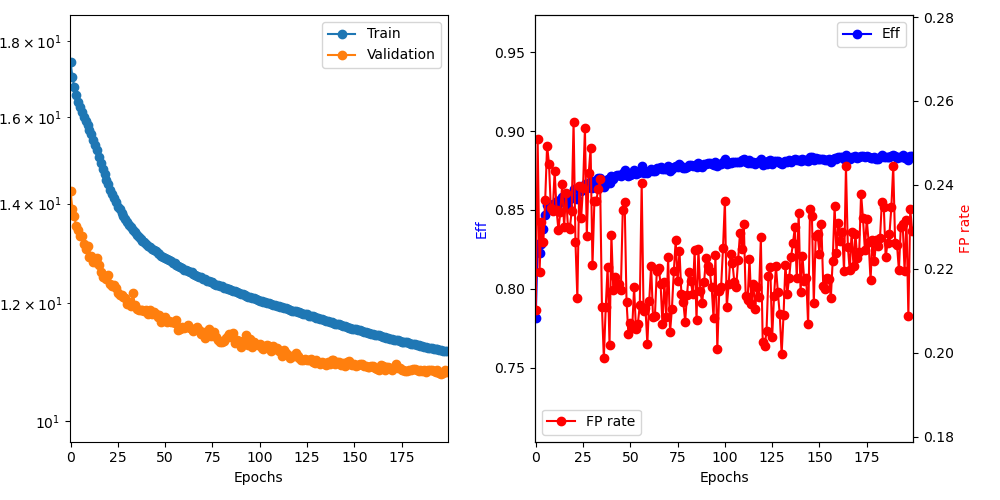

In [11]:
ax, tax, lax, lines = dual_train_plots()
fig = ax.figure
plt.tight_layout()
# This gets built up during the run - do not rerun this cell
results = pd.DataFrame([], columns=Results._fields)

for model:  ACN_1_10L_4S(
  (conv1): Conv1d(1, 20, kernel_size=(25,), stride=(1,), padding=(12,))
  (conv2): Conv1d(20, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv3): Conv1d(30, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv4): Conv1d(10, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv5): Conv1d(20, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv6): Conv1d(10, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv7): Conv1d(20, 7, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv8): Conv1d(7, 3, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv9): Conv1d(10, 1, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv1dropout): Dropout(p=0.15, inplace=False)
  (conv2dropout): Dropout(p=0.15, inplace=False)
  (conv3dropout): Dropout(p=0.15, inplace=False)
  (conv4dropout): Dropout(p=0.15, inplace=False)
  (conv5dropout): Dropout(p=0.15, inplace=False)
  (conv6dropout): Dropout(p=0.15, inplace=False)
  (conv7dropout): Dropout(p=0.15, inpla

/home/michael24peters/pv-finder/notebooks/model/training.py:95: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 20: train=17.4134, val=14.2681, took 41.333 s
  Validation Found 84375 of 108007, added 4203 (eff 78.12%) (0.21 FP/event)


Epoch 21: train=17.0335, val=13.8848, took 40.127 s
  Validation Found 89447 of 108007, added 5021 (eff 82.82%) (0.251 FP/event)


Epoch 22: train=16.7584, val=13.7261, took 40.137 s
  Validation Found 88876 of 108007, added 4386 (eff 82.29%) (0.219 FP/event)


Epoch 23: train=16.5569, val=13.5243, took 41.51 s
  Validation Found 89486 of 108007, added 4624 (eff 82.85%) (0.231 FP/event)


Epoch 24: train=16.388, val=13.435, took 40.175 s
  Validation Found 90467 of 108007, added 4527 (eff 83.76%) (0.226 FP/event)


Epoch 25: train=16.2604, val=13.3191, took 40.147 s
  Validation Found 91481 of 108007, added 4728 (eff 84.70%) (0.236 FP/event)


Epoch 26: train=16.1171, val=13.3075, took 40.771 s
  Validation Found 92127 of 108007, added 4988 (eff 85.30%) (0.249 FP/event)


Epoch 27: train=16.0165, val=13.1474, took 40.889 s
  Validation Found 91949 of 108007, added 4901 (eff 85.13%) (0.245 FP/event)


Epoch 28: train=15.9004, val=13.0598, took 40.188 s
  Validation Found 91845 of 108007, added 4689 (eff 85.04%) (0.234 FP/event)


Epoch 29: train=15.7966, val=13.1034, took 40.176 s
  Validation Found 92235 of 108007, added 4678 (eff 85.40%) (0.234 FP/event)


Epoch 30: train=15.6893, val=12.896, took 40.177 s
  Validation Found 92150 of 108007, added 4867 (eff 85.32%) (0.243 FP/event)


Epoch 31: train=15.5814, val=12.9196, took 40.171 s
  Validation Found 92429 of 108007, added 4682 (eff 85.58%) (0.234 FP/event)


Epoch 32: train=15.4488, val=12.7936, took 40.186 s
  Validation Found 92208 of 108007, added 4584 (eff 85.37%) (0.229 FP/event)


Epoch 33: train=15.3272, val=12.7834, took 40.96 s
  Validation Found 92483 of 108007, added 4673 (eff 85.63%) (0.234 FP/event)


Epoch 34: train=15.203, val=12.8714, took 40.282 s
  Validation Found 92706 of 108007, added 4806 (eff 85.83%) (0.24 FP/event)


Epoch 35: train=15.0447, val=12.7323, took 41.588 s
  Validation Found 92449 of 108007, added 4600 (eff 85.60%) (0.23 FP/event)


Epoch 36: train=14.8998, val=12.6004, took 41.09 s
  Validation Found 92642 of 108007, added 4764 (eff 85.77%) (0.238 FP/event)


Epoch 37: train=14.7637, val=12.501, took 41.57 s
  Validation Found 91998 of 108007, added 4600 (eff 85.18%) (0.23 FP/event)


Epoch 38: train=14.6447, val=12.5082, took 41.563 s
  Validation Found 92555 of 108007, added 4590 (eff 85.69%) (0.229 FP/event)


Epoch 39: train=14.5317, val=12.4536, took 41.561 s
  Validation Found 92702 of 108007, added 4677 (eff 85.83%) (0.234 FP/event)


Epoch 40: train=14.421, val=12.5312, took 40.265 s
  Validation Found 93230 of 108007, added 5100 (eff 86.32%) (0.255 FP/event)


Epoch 41: train=14.3073, val=12.3714, took 40.187 s
  Validation Found 92631 of 108007, added 4528 (eff 85.76%) (0.226 FP/event)


Epoch 42: train=14.2162, val=12.3308, took 40.207 s
  Validation Found 92530 of 108007, added 4261 (eff 85.67%) (0.213 FP/event)


Epoch 43: train=14.1125, val=12.3454, took 40.206 s
  Validation Found 93225 of 108007, added 4793 (eff 86.31%) (0.24 FP/event)


Epoch 44: train=14.0275, val=12.2933, took 40.228 s
  Validation Found 93114 of 108007, added 4642 (eff 86.21%) (0.232 FP/event)


Epoch 45: train=13.9357, val=12.1921, took 40.694 s
  Validation Found 93295 of 108007, added 4786 (eff 86.38%) (0.239 FP/event)


Epoch 46: train=13.8785, val=12.1649, took 40.165 s
  Validation Found 93585 of 108007, added 5070 (eff 86.65%) (0.253 FP/event)


Epoch 47: train=13.8018, val=12.1613, took 41.52 s
  Validation Found 93289 of 108007, added 4559 (eff 86.37%) (0.228 FP/event)


Epoch 48: train=13.7273, val=12.1202, took 40.221 s
  Validation Found 93659 of 108007, added 4855 (eff 86.72%) (0.243 FP/event)


Epoch 49: train=13.6668, val=12.0923, took 40.222 s
  Validation Found 93778 of 108007, added 4975 (eff 86.83%) (0.249 FP/event)


Epoch 50: train=13.6058, val=11.9877, took 40.282 s
  Validation Found 93274 of 108007, added 4417 (eff 86.36%) (0.221 FP/event)


Epoch 51: train=13.5435, val=12.026, took 40.471 s
  Validation Found 93778 of 108007, added 4723 (eff 86.83%) (0.236 FP/event)


Epoch 52: train=13.495, val=11.9552, took 40.231 s
  Validation Found 93807 of 108007, added 4724 (eff 86.85%) (0.236 FP/event)


Epoch 53: train=13.4368, val=12.196, took 40.201 s
  Validation Found 93996 of 108007, added 4779 (eff 87.03%) (0.239 FP/event)


Epoch 54: train=13.3922, val=11.9675, took 40.572 s
  Validation Found 93966 of 108007, added 4827 (eff 87.00%) (0.241 FP/event)


Epoch 55: train=13.3466, val=11.9055, took 40.174 s
  Validation Found 93584 of 108007, added 4219 (eff 86.65%) (0.211 FP/event)


Epoch 56: train=13.3042, val=11.8847, took 40.246 s
  Validation Found 93340 of 108007, added 3974 (eff 86.42%) (0.199 FP/event)


Epoch 57: train=13.2581, val=11.8712, took 40.208 s
  Validation Found 93609 of 108007, added 4217 (eff 86.67%) (0.211 FP/event)


Epoch 58: train=13.222, val=11.8761, took 40.228 s
  Validation Found 93924 of 108007, added 4411 (eff 86.96%) (0.221 FP/event)


Epoch 59: train=13.1908, val=11.8668, took 40.239 s
  Validation Found 93638 of 108007, added 4037 (eff 86.70%) (0.202 FP/event)


Epoch 60: train=13.1515, val=11.8706, took 41.581 s
  Validation Found 94112 of 108007, added 4560 (eff 87.14%) (0.228 FP/event)


Epoch 61: train=13.1173, val=11.8071, took 40.897 s
  Validation Found 93931 of 108007, added 4301 (eff 86.97%) (0.215 FP/event)


Epoch 62: train=13.0873, val=11.8814, took 40.283 s
  Validation Found 94111 of 108007, added 4363 (eff 87.13%) (0.218 FP/event)


Epoch 63: train=13.0605, val=11.7999, took 41.537 s
  Validation Found 94174 of 108007, added 4329 (eff 87.19%) (0.216 FP/event)


Epoch 64: train=13.0333, val=11.8328, took 40.464 s
  Validation Found 94185 of 108007, added 4328 (eff 87.20%) (0.216 FP/event)


Epoch 65: train=13.0027, val=11.8073, took 41.589 s
  Validation Found 94132 of 108007, added 4300 (eff 87.15%) (0.215 FP/event)


Epoch 66: train=12.9807, val=11.7552, took 41.54 s
  Validation Found 94362 of 108007, added 4679 (eff 87.37%) (0.234 FP/event)


Epoch 67: train=12.9534, val=11.7778, took 40.216 s
  Validation Found 94524 of 108007, added 4720 (eff 87.52%) (0.236 FP/event)


Epoch 68: train=12.9175, val=11.6678, took 40.154 s
  Validation Found 94222 of 108007, added 4244 (eff 87.24%) (0.212 FP/event)


Epoch 69: train=12.9001, val=11.7264, took 40.183 s
  Validation Found 94100 of 108007, added 4089 (eff 87.12%) (0.204 FP/event)


Epoch 70: train=12.8729, val=11.756, took 41.407 s
  Validation Found 94176 of 108007, added 4143 (eff 87.19%) (0.207 FP/event)


Epoch 71: train=12.8515, val=11.667, took 41.457 s
  Validation Found 94238 of 108007, added 4119 (eff 87.25%) (0.206 FP/event)


Epoch 72: train=12.8257, val=11.6823, took 41.553 s
  Validation Found 94509 of 108007, added 4312 (eff 87.50%) (0.216 FP/event)


Epoch 73: train=12.8103, val=11.6611, took 40.7 s
  Validation Found 94297 of 108007, added 4113 (eff 87.31%) (0.206 FP/event)


Epoch 74: train=12.7803, val=11.6594, took 41.081 s
  Validation Found 94337 of 108007, added 4139 (eff 87.34%) (0.207 FP/event)


Epoch 75: train=12.7638, val=11.6466, took 40.223 s
  Validation Found 94415 of 108007, added 4228 (eff 87.42%) (0.211 FP/event)


Epoch 76: train=12.7364, val=11.6879, took 40.184 s
  Validation Found 94815 of 108007, added 4810 (eff 87.79%) (0.24 FP/event)


Epoch 77: train=12.7158, val=11.5192, took 40.179 s
  Validation Found 94318 of 108007, added 4200 (eff 87.33%) (0.21 FP/event)


Epoch 78: train=12.6957, val=11.5299, took 41.569 s
  Validation Found 94437 of 108007, added 4213 (eff 87.44%) (0.211 FP/event)


Epoch 79: train=12.6724, val=11.5705, took 40.169 s
  Validation Found 94362 of 108007, added 4044 (eff 87.37%) (0.202 FP/event)


Epoch 80: train=12.644, val=11.5463, took 40.264 s
  Validation Found 94450 of 108007, added 4249 (eff 87.45%) (0.212 FP/event)


Epoch 81: train=12.6347, val=11.571, took 40.137 s
  Validation Found 94577 of 108007, added 4416 (eff 87.57%) (0.221 FP/event)


Epoch 82: train=12.6126, val=11.6001, took 40.162 s
  Validation Found 94498 of 108007, added 4171 (eff 87.49%) (0.209 FP/event)


Epoch 83: train=12.5919, val=11.5562, took 40.182 s
  Validation Found 94492 of 108007, added 4174 (eff 87.49%) (0.209 FP/event)


Epoch 84: train=12.5871, val=11.5415, took 40.154 s
  Validation Found 94685 of 108007, added 4389 (eff 87.67%) (0.219 FP/event)


Epoch 85: train=12.5604, val=11.4912, took 40.174 s
  Validation Found 94695 of 108007, added 4406 (eff 87.67%) (0.22 FP/event)


Epoch 86: train=12.5445, val=11.5309, took 40.17 s
  Validation Found 94732 of 108007, added 4328 (eff 87.71%) (0.216 FP/event)


Epoch 87: train=12.5151, val=11.5649, took 40.177 s
  Validation Found 94585 of 108007, added 4137 (eff 87.57%) (0.207 FP/event)


Epoch 88: train=12.5044, val=11.5114, took 40.25 s
  Validation Found 94627 of 108007, added 4338 (eff 87.61%) (0.217 FP/event)


Epoch 89: train=12.4912, val=11.4546, took 41.428 s
  Validation Found 94595 of 108007, added 4170 (eff 87.58%) (0.208 FP/event)


Epoch 90: train=12.4662, val=11.4887, took 40.891 s
  Validation Found 94804 of 108007, added 4459 (eff 87.78%) (0.223 FP/event)


Epoch 91: train=12.4562, val=11.3775, took 40.149 s
  Validation Found 94449 of 108007, added 4098 (eff 87.45%) (0.205 FP/event)


Epoch 92: train=12.4321, val=11.4127, took 40.172 s
  Validation Found 94635 of 108007, added 4211 (eff 87.62%) (0.211 FP/event)


Epoch 93: train=12.4253, val=11.5307, took 41.527 s
  Validation Found 94764 of 108007, added 4389 (eff 87.74%) (0.219 FP/event)


Epoch 94: train=12.4077, val=11.4143, took 40.163 s
  Validation Found 94836 of 108007, added 4536 (eff 87.81%) (0.227 FP/event)


Epoch 95: train=12.3959, val=11.4268, took 40.163 s
  Validation Found 94774 of 108007, added 4341 (eff 87.75%) (0.217 FP/event)


Epoch 96: train=12.3696, val=11.4742, took 40.164 s
  Validation Found 94924 of 108007, added 4486 (eff 87.89%) (0.224 FP/event)


Epoch 97: train=12.3544, val=11.3936, took 40.255 s
  Validation Found 94813 of 108007, added 4279 (eff 87.78%) (0.214 FP/event)


Epoch 98: train=12.3451, val=11.3413, took 40.182 s
  Validation Found 94660 of 108007, added 4243 (eff 87.64%) (0.212 FP/event)


Epoch 99: train=12.3298, val=11.3122, took 40.149 s
  Validation Found 94656 of 108007, added 4149 (eff 87.64%) (0.207 FP/event)


Epoch 100: train=12.3183, val=11.3034, took 40.343 s
  Validation Found 94728 of 108007, added 4278 (eff 87.71%) (0.214 FP/event)


Epoch 101: train=12.2966, val=11.329, took 41.414 s
  Validation Found 94861 of 108007, added 4386 (eff 87.83%) (0.219 FP/event)


Epoch 102: train=12.2856, val=11.3819, took 40.278 s
  Validation Found 94864 of 108007, added 4343 (eff 87.83%) (0.217 FP/event)


Epoch 103: train=12.2711, val=11.4155, took 40.174 s
  Validation Found 94834 of 108007, added 4280 (eff 87.80%) (0.214 FP/event)


Epoch 104: train=12.2613, val=11.4445, took 40.179 s
  Validation Found 94905 of 108007, added 4489 (eff 87.87%) (0.224 FP/event)


Epoch 105: train=12.2427, val=11.3958, took 40.126 s
  Validation Found 94765 of 108007, added 4156 (eff 87.74%) (0.208 FP/event)


Epoch 106: train=12.2331, val=11.455, took 40.133 s
  Validation Found 94989 of 108007, added 4493 (eff 87.95%) (0.225 FP/event)


Epoch 107: train=12.2272, val=11.2814, took 40.183 s
  Validation Found 94825 of 108007, added 4294 (eff 87.80%) (0.215 FP/event)


Epoch 108: train=12.2071, val=11.3379, took 40.581 s
  Validation Found 94766 of 108007, added 4237 (eff 87.74%) (0.212 FP/event)


Epoch 109: train=12.1924, val=11.3277, took 40.129 s
  Validation Found 94952 of 108007, added 4337 (eff 87.91%) (0.217 FP/event)


Epoch 110: train=12.1804, val=11.2122, took 40.275 s
  Validation Found 94972 of 108007, added 4450 (eff 87.93%) (0.222 FP/event)


Epoch 111: train=12.1734, val=11.3265, took 41.426 s
  Validation Found 94992 of 108007, added 4413 (eff 87.95%) (0.221 FP/event)


Epoch 112: train=12.1545, val=11.2891, took 40.227 s
  Validation Found 95010 of 108007, added 4389 (eff 87.97%) (0.219 FP/event)


Epoch 113: train=12.1398, val=11.4335, took 40.754 s
  Validation Found 94973 of 108007, added 4314 (eff 87.93%) (0.216 FP/event)


Epoch 114: train=12.1275, val=11.2547, took 40.158 s
  Validation Found 94911 of 108007, added 4164 (eff 87.87%) (0.208 FP/event)


Epoch 115: train=12.1171, val=11.3591, took 40.888 s
  Validation Found 95058 of 108007, added 4464 (eff 88.01%) (0.223 FP/event)


Epoch 116: train=12.1019, val=11.2214, took 41.347 s
  Validation Found 94820 of 108007, added 4017 (eff 87.79%) (0.201 FP/event)


Epoch 117: train=12.0962, val=11.3043, took 40.146 s
  Validation Found 94972 of 108007, added 4293 (eff 87.93%) (0.215 FP/event)


Epoch 118: train=12.0796, val=11.2697, took 41.52 s
  Validation Found 94973 of 108007, added 4314 (eff 87.93%) (0.216 FP/event)


Epoch 119: train=12.067, val=11.252, took 41.21 s
  Validation Found 95073 of 108007, added 4498 (eff 88.02%) (0.225 FP/event)


Epoch 120: train=12.0533, val=11.272, took 40.198 s
  Validation Found 95276 of 108007, added 4726 (eff 88.21%) (0.236 FP/event)


Epoch 121: train=12.0479, val=11.197, took 40.141 s
  Validation Found 94920 of 108007, added 4219 (eff 87.88%) (0.211 FP/event)


Epoch 122: train=12.035, val=11.1774, took 41.414 s
  Validation Found 95033 of 108007, added 4326 (eff 87.99%) (0.216 FP/event)


Epoch 123: train=12.0218, val=11.2374, took 41.45 s
  Validation Found 95034 of 108007, added 4471 (eff 87.99%) (0.224 FP/event)


Epoch 124: train=12.0113, val=11.261, took 40.861 s
  Validation Found 95100 of 108007, added 4429 (eff 88.05%) (0.221 FP/event)


Epoch 125: train=12.0023, val=11.2313, took 40.241 s
  Validation Found 95082 of 108007, added 4336 (eff 88.03%) (0.217 FP/event)


Epoch 126: train=11.9873, val=11.1473, took 41.582 s
  Validation Found 95070 of 108007, added 4315 (eff 88.02%) (0.216 FP/event)


Epoch 127: train=11.9729, val=11.2329, took 41.669 s
  Validation Found 95094 of 108007, added 4444 (eff 88.04%) (0.222 FP/event)


Epoch 128: train=11.9702, val=11.192, took 41.586 s
  Validation Found 95098 of 108007, added 4573 (eff 88.05%) (0.229 FP/event)


Epoch 129: train=11.956, val=11.1991, took 40.197 s
  Validation Found 95246 of 108007, added 4496 (eff 88.19%) (0.225 FP/event)


Epoch 130: train=11.9451, val=11.1527, took 41.606 s
  Validation Found 95273 of 108007, added 4612 (eff 88.21%) (0.231 FP/event)


Epoch 131: train=11.9406, val=11.1528, took 41.594 s
  Validation Found 95098 of 108007, added 4270 (eff 88.05%) (0.213 FP/event)


Epoch 132: train=11.926, val=11.0688, took 40.187 s
  Validation Found 95025 of 108007, added 4251 (eff 87.98%) (0.213 FP/event)


Epoch 133: train=11.916, val=11.1645, took 40.207 s
  Validation Found 95214 of 108007, added 4447 (eff 88.16%) (0.222 FP/event)


Epoch 134: train=11.909, val=11.1161, took 41.526 s
  Validation Found 95028 of 108007, added 4231 (eff 87.98%) (0.212 FP/event)


Epoch 135: train=11.8977, val=11.0814, took 41.492 s
  Validation Found 95090 of 108007, added 4330 (eff 88.04%) (0.216 FP/event)


Epoch 136: train=11.8767, val=11.0266, took 40.23 s
  Validation Found 94962 of 108007, added 4209 (eff 87.92%) (0.21 FP/event)


Epoch 137: train=11.8685, val=11.0677, took 41.611 s
  Validation Found 95110 of 108007, added 4312 (eff 88.06%) (0.216 FP/event)


Epoch 138: train=11.8687, val=11.0687, took 40.185 s
  Validation Found 95094 of 108007, added 4267 (eff 88.04%) (0.213 FP/event)


Epoch 139: train=11.8545, val=11.1101, took 41.573 s
  Validation Found 95317 of 108007, added 4550 (eff 88.25%) (0.227 FP/event)


Epoch 140: train=11.8447, val=11.0568, took 40.244 s
  Validation Found 94894 of 108007, added 4052 (eff 87.86%) (0.203 FP/event)


Epoch 141: train=11.8352, val=11.0339, took 40.167 s
  Validation Found 94986 of 108007, added 4032 (eff 87.94%) (0.202 FP/event)


Epoch 142: train=11.8214, val=11.0012, took 40.63 s
  Validation Found 94948 of 108007, added 4103 (eff 87.91%) (0.205 FP/event)


Epoch 143: train=11.8126, val=11.002, took 40.892 s
  Validation Found 95161 of 108007, added 4366 (eff 88.11%) (0.218 FP/event)


Epoch 144: train=11.8004, val=11.0178, took 40.206 s
  Validation Found 95224 of 108007, added 4408 (eff 88.16%) (0.22 FP/event)


Epoch 145: train=11.7967, val=11.0035, took 40.999 s
  Validation Found 94916 of 108007, added 4076 (eff 87.88%) (0.204 FP/event)


Epoch 146: train=11.7755, val=10.9964, took 41.864 s
  Validation Found 95147 of 108007, added 4273 (eff 88.09%) (0.214 FP/event)


Epoch 147: train=11.7706, val=11.0058, took 41.421 s
  Validation Found 95171 of 108007, added 4413 (eff 88.12%) (0.221 FP/event)


Epoch 148: train=11.7629, val=10.9561, took 40.464 s
  Validation Found 95138 of 108007, added 4289 (eff 88.09%) (0.214 FP/event)


Epoch 149: train=11.7555, val=10.9442, took 41.603 s
  Validation Found 95001 of 108007, added 4183 (eff 87.96%) (0.209 FP/event)


Epoch 150: train=11.738, val=11.0033, took 41.628 s
  Validation Found 94926 of 108007, added 3993 (eff 87.89%) (0.2 FP/event)


Epoch 151: train=11.7281, val=10.9576, took 40.339 s
  Validation Found 95079 of 108007, added 4180 (eff 88.03%) (0.209 FP/event)


Epoch 152: train=11.7124, val=10.9343, took 41.56 s
  Validation Found 95124 of 108007, added 4420 (eff 88.07%) (0.221 FP/event)


Epoch 153: train=11.7053, val=10.9544, took 40.281 s
  Validation Found 95116 of 108007, added 4282 (eff 88.06%) (0.214 FP/event)


Epoch 154: train=11.7005, val=10.952, took 40.278 s
  Validation Found 95202 of 108007, added 4359 (eff 88.14%) (0.218 FP/event)


Epoch 155: train=11.684, val=10.915, took 41.274 s
  Validation Found 95110 of 108007, added 4457 (eff 88.06%) (0.223 FP/event)


Epoch 156: train=11.6768, val=10.9611, took 40.762 s
  Validation Found 95206 of 108007, added 4523 (eff 88.15%) (0.226 FP/event)


Epoch 157: train=11.6669, val=10.933, took 40.236 s
  Validation Found 95274 of 108007, added 4600 (eff 88.21%) (0.23 FP/event)


Epoch 158: train=11.6516, val=10.9955, took 40.178 s
  Validation Found 95230 of 108007, added 4355 (eff 88.17%) (0.218 FP/event)


Epoch 159: train=11.6387, val=10.9873, took 40.169 s
  Validation Found 95245 of 108007, added 4666 (eff 88.18%) (0.233 FP/event)


Epoch 160: train=11.6289, val=10.9339, took 40.22 s
  Validation Found 95128 of 108007, added 4290 (eff 88.08%) (0.214 FP/event)


Epoch 161: train=11.6294, val=10.9607, took 40.53 s
  Validation Found 95272 of 108007, added 4462 (eff 88.21%) (0.223 FP/event)


Epoch 162: train=11.6175, val=10.9603, took 41.39 s
  Validation Found 95201 of 108007, added 4341 (eff 88.14%) (0.217 FP/event)


Epoch 163: train=11.607, val=10.9142, took 40.323 s
  Validation Found 95204 of 108007, added 4357 (eff 88.15%) (0.218 FP/event)


Epoch 164: train=11.5924, val=10.9467, took 40.805 s
  Validation Found 95137 of 108007, added 4136 (eff 88.08%) (0.207 FP/event)


Epoch 165: train=11.589, val=10.8937, took 41.607 s
  Validation Found 95402 of 108007, added 4684 (eff 88.33%) (0.234 FP/event)


Epoch 166: train=11.5736, val=10.9547, took 41.611 s
  Validation Found 95411 of 108007, added 4654 (eff 88.34%) (0.233 FP/event)


Epoch 167: train=11.557, val=10.9764, took 41.133 s
  Validation Found 95190 of 108007, added 4237 (eff 88.13%) (0.212 FP/event)


Epoch 168: train=11.5583, val=10.9269, took 40.269 s
  Validation Found 95366 of 108007, added 4556 (eff 88.30%) (0.228 FP/event)


Epoch 169: train=11.5421, val=10.9117, took 41.67 s
  Validation Found 95271 of 108007, added 4566 (eff 88.21%) (0.228 FP/event)


Epoch 170: train=11.5315, val=10.9239, took 41.651 s
  Validation Found 95316 of 108007, added 4471 (eff 88.25%) (0.224 FP/event)


Epoch 171: train=11.53, val=10.8965, took 40.425 s
  Validation Found 95261 of 108007, added 4614 (eff 88.20%) (0.231 FP/event)


Epoch 172: train=11.5119, val=10.9105, took 41.632 s
  Validation Found 95257 of 108007, added 4317 (eff 88.20%) (0.216 FP/event)


Epoch 173: train=11.5081, val=10.9275, took 40.229 s
  Validation Found 95193 of 108007, added 4302 (eff 88.14%) (0.215 FP/event)


Epoch 174: train=11.4969, val=10.9218, took 40.21 s
  Validation Found 95251 of 108007, added 4357 (eff 88.19%) (0.218 FP/event)


Epoch 175: train=11.4809, val=10.8931, took 40.466 s
  Validation Found 95300 of 108007, added 4353 (eff 88.24%) (0.218 FP/event)


Epoch 176: train=11.475, val=10.8923, took 40.635 s
  Validation Found 95081 of 108007, added 4261 (eff 88.03%) (0.213 FP/event)


Epoch 177: train=11.4695, val=10.8686, took 40.222 s
  Validation Found 95305 of 108007, added 4440 (eff 88.24%) (0.222 FP/event)


Epoch 178: train=11.4582, val=10.8802, took 40.714 s
  Validation Found 95330 of 108007, added 4699 (eff 88.26%) (0.235 FP/event)


Epoch 179: train=11.4439, val=10.8973, took 41.665 s
  Validation Found 95281 of 108007, added 4478 (eff 88.22%) (0.224 FP/event)


Epoch 180: train=11.4377, val=10.9012, took 41.464 s
  Validation Found 95433 of 108007, added 4620 (eff 88.36%) (0.231 FP/event)


Epoch 181: train=11.4264, val=10.8656, took 41.617 s
  Validation Found 95426 of 108007, added 4533 (eff 88.35%) (0.227 FP/event)


Epoch 182: train=11.4241, val=10.8485, took 40.669 s
  Validation Found 95417 of 108007, added 4574 (eff 88.34%) (0.229 FP/event)


Epoch 183: train=11.4215, val=10.8219, took 41.671 s
  Validation Found 95301 of 108007, added 4390 (eff 88.24%) (0.219 FP/event)


Epoch 184: train=11.4074, val=10.9037, took 40.58 s
  Validation Found 95565 of 108007, added 4889 (eff 88.48%) (0.244 FP/event)


Epoch 185: train=11.3948, val=10.8908, took 40.927 s
  Validation Found 95424 of 108007, added 4504 (eff 88.35%) (0.225 FP/event)


Epoch 186: train=11.3878, val=10.823, took 41.647 s
  Validation Found 95265 of 108007, added 4394 (eff 88.20%) (0.22 FP/event)


Epoch 187: train=11.3768, val=10.8728, took 41.615 s
  Validation Found 95438 of 108007, added 4574 (eff 88.36%) (0.229 FP/event)


Epoch 188: train=11.3743, val=10.8848, took 41.66 s
  Validation Found 95398 of 108007, added 4412 (eff 88.33%) (0.221 FP/event)


Epoch 189: train=11.3629, val=10.8561, took 40.221 s
  Validation Found 95481 of 108007, added 4566 (eff 88.40%) (0.228 FP/event)


Epoch 190: train=11.3528, val=10.8297, took 40.221 s
  Validation Found 95353 of 108007, added 4452 (eff 88.28%) (0.223 FP/event)


Epoch 191: train=11.3451, val=10.8556, took 41.331 s
  Validation Found 95424 of 108007, added 4481 (eff 88.35%) (0.224 FP/event)


Epoch 192: train=11.335, val=10.9254, took 40.46 s
  Validation Found 95502 of 108007, added 4758 (eff 88.42%) (0.238 FP/event)


Epoch 193: train=11.3319, val=10.863, took 40.252 s
  Validation Found 95473 of 108007, added 4641 (eff 88.40%) (0.232 FP/event)


Epoch 194: train=11.3252, val=10.8564, took 41.483 s
  Validation Found 95415 of 108007, added 4491 (eff 88.34%) (0.225 FP/event)


Epoch 195: train=11.3135, val=10.8323, took 40.197 s
  Validation Found 95494 of 108007, added 4636 (eff 88.41%) (0.232 FP/event)


Epoch 196: train=11.3089, val=10.8196, took 40.19 s
  Validation Found 95417 of 108007, added 4528 (eff 88.34%) (0.226 FP/event)


Epoch 197: train=11.2981, val=10.8147, took 40.191 s
  Validation Found 95338 of 108007, added 4346 (eff 88.27%) (0.217 FP/event)


Epoch 198: train=11.297, val=10.8122, took 40.21 s
  Validation Found 95358 of 108007, added 4537 (eff 88.29%) (0.227 FP/event)


Epoch 199: train=11.2861, val=10.8341, took 40.22 s
  Validation Found 95412 of 108007, added 4436 (eff 88.34%) (0.222 FP/event)


Epoch 200: train=11.2706, val=10.827, took 41.569 s
  Validation Found 95303 of 108007, added 4537 (eff 88.24%) (0.227 FP/event)


Epoch 201: train=11.2692, val=10.8368, took 40.979 s
  Validation Found 95305 of 108007, added 4511 (eff 88.24%) (0.226 FP/event)


Epoch 202: train=11.2624, val=10.8361, took 40.66 s
  Validation Found 95428 of 108007, added 4546 (eff 88.35%) (0.227 FP/event)


Epoch 203: train=11.2577, val=10.8198, took 40.191 s
  Validation Found 95531 of 108007, added 4721 (eff 88.45%) (0.236 FP/event)


Epoch 204: train=11.2533, val=10.8082, took 40.247 s
  Validation Found 95452 of 108007, added 4697 (eff 88.38%) (0.235 FP/event)


Epoch 205: train=11.2417, val=10.8211, took 40.24 s
  Validation Found 95403 of 108007, added 4455 (eff 88.33%) (0.223 FP/event)


Epoch 206: train=11.2344, val=10.8176, took 40.206 s
  Validation Found 95428 of 108007, added 4524 (eff 88.35%) (0.226 FP/event)


Epoch 207: train=11.2186, val=10.8218, took 40.219 s
  Validation Found 95416 of 108007, added 4566 (eff 88.34%) (0.228 FP/event)


Epoch 208: train=11.2159, val=10.7877, took 40.208 s
  Validation Found 95521 of 108007, added 4693 (eff 88.44%) (0.235 FP/event)


Epoch 209: train=11.2089, val=10.8295, took 41.266 s
  Validation Found 95589 of 108007, added 4890 (eff 88.50%) (0.244 FP/event)


Epoch 210: train=11.2077, val=10.8207, took 40.776 s
  Validation Found 95510 of 108007, added 4525 (eff 88.43%) (0.226 FP/event)


Epoch 211: train=11.193, val=10.8306, took 41.112 s
  Validation Found 95389 of 108007, added 4514 (eff 88.32%) (0.226 FP/event)


Epoch 212: train=11.1857, val=10.817, took 40.198 s
  Validation Found 95405 of 108007, added 4393 (eff 88.33%) (0.22 FP/event)


Epoch 213: train=11.1834, val=10.7963, took 40.2 s
  Validation Found 95420 of 108007, added 4602 (eff 88.35%) (0.23 FP/event)


Epoch 214: train=11.1758, val=10.8274, took 40.213 s
  Validation Found 95545 of 108007, added 4614 (eff 88.46%) (0.231 FP/event)


Epoch 215: train=11.1656, val=10.769, took 40.188 s
  Validation Found 95348 of 108007, added 4391 (eff 88.28%) (0.22 FP/event)


Epoch 216: train=11.1642, val=10.7677, took 40.182 s
  Validation Found 95444 of 108007, added 4634 (eff 88.37%) (0.232 FP/event)


Epoch 217: train=11.1534, val=10.7844, took 40.197 s
  Validation Found 95234 of 108007, added 4178 (eff 88.17%) (0.209 FP/event)


Epoch 218: train=11.1469, val=10.8206, took 40.191 s
  Validation Found 95521 of 108007, added 4684 (eff 88.44%) (0.234 FP/event)


Epoch 219: train=11.1416, val=10.7852, took 41.544 s
  Validation Found 95506 of 108007, added 4583 (eff 88.43%) (0.229 FP/event)
Averaging...

Average Eff:  0.8835742127825048
Average FP Rate:  0.22557872106394683



<IPython.core.display.Javascript object>


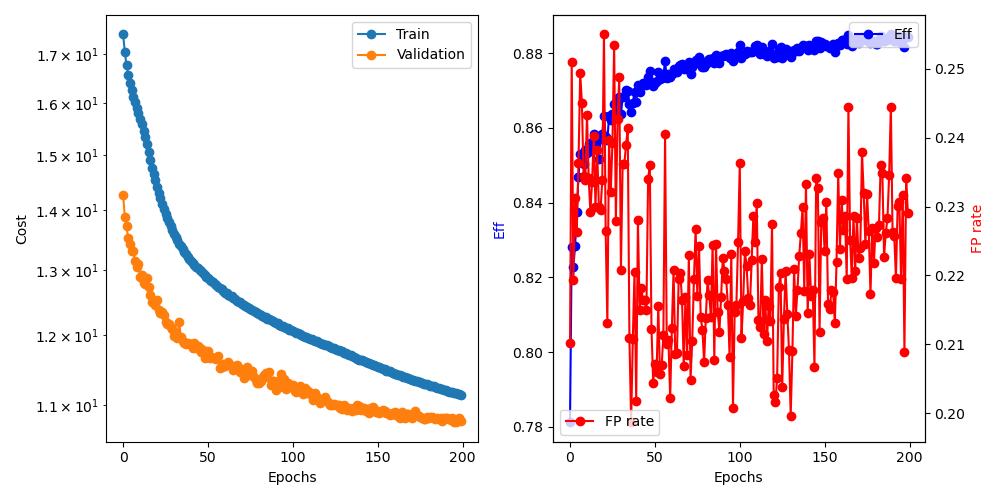

In [12]:
avgEff = 0.0
avgFP = 0.0
print('for model: ', model)   
run_name = 'ACN_1_10L_4S (P2)'
# Create an mlflow run
with mlflow.start_run(run_name=run_name) as run:
    # Log parameters of the model
    for key, value in vars(args).items():
        print(key, value)
        mlflow.log_param(key, value)
    
    # Log parameter count in the model
    mlflow.log_param('Parameters', count_parameters(model))
    
    # Begin run
    for result in trainNet(model, optimizer, loss,
                            train_loader, val_loader,
                            args.epochs+args.epoch_start, epoch_start=args.epoch_start,
                            notebook=True, device=device):

        result = result._asdict()
        results = results.append(pd.Series(result), ignore_index=True)
        xs = results.index

        # Update the plot above
        lines['train'].set_data(results.index, results.cost)
        lines['val'].set_data(results.index, results.val)

        #filter first cost epoch (can be really large)
        max_cost = max(max(results.cost if len(results.cost)<2 else results.cost[1:]), max(results.val))
        min_cost = min(min(results.cost), min(results.val))
    
        # The plot limits need updating too
        ax.set_ylim(min_cost*.9, max_cost*1.1)  
        ax.set_xlim(-.5, len(results.cost) - .5)
    
        replace_in_ax(lax, lines['eff'], xs, results['eff_val'].apply(lambda x: x.eff_rate))
        replace_in_ax(tax, lines['fp'], xs, results['eff_val'].apply(lambda x: x.fp_rate))            
            
        # Redraw the figure
        fig.canvas.draw()
            
        ## MLFLOW ##
        # Log metrics
        mlflow.log_metric('Efficiency', result['eff_val'].eff_rate, result['epoch'])
        mlflow.log_metric('False Positive Rate',  result['eff_val'].fp_rate, result['epoch'])
        mlflow.log_metric('Validation Loss',  result['val'], result['epoch'])
        mlflow.log_metric('Training Loss',  result['cost'], result['epoch'])
        
        if(result['epoch'] >= args.epochs + args.epoch_start - 10):
            avgEff += result['eff_val'].eff_rate
            avgFP += result['eff_val'].fp_rate
           
        if(result['epoch'] == args.epochs + args.epoch_start - 1):
            print('Averaging...\n')
            avgEff /= 10
            avgFP /= 10
            mlflow.log_metric('10 Efficiency Average', avgEff)
            mlflow.log_metric('10 False Positive Average', avgFP)
            print('Average Eff: ', avgEff)
            print('Average FP Rate: ', avgFP)
            
        
        # Log tags
#        mlflow.set_tag('Optimizer', 'Adam')
#        mlflow.set_tag('Kernel size', 'Mixed')
#        mlflow.set_tag('Skip connections', '4')
#        mlflow.set_tag('Activation', 'Softplus')
#        mlflow.set_tag('Mid Activation', 'Relu')
        mlflow.set_tag('Asymmetry', '2.5')
        mlflow.set_tag('KDE', 'Poca')

        # Save model state dictionary, optimizer state dictionary, and epoch number
        torch.save({
            'model':model.state_dict(),
            'optimizer':optimizer.state_dict(),
            'epoch':args.epochs+result['epoch']
            }, 'run_stats.pyt')
        # Save the run stats into mlflow
        mlflow.log_artifact('run_stats.pyt')
        
    dual_train_plots(results.index,
                 results.cost, results.val, 
                 results['eff_val'].apply(lambda x: x.eff_rate),
                 results['eff_val'].apply(lambda x: x.fp_rate))
    plt.tight_layout()
    # save plot
    plt.savefig('plot.png')  
    mlflow.log_artifact('plot.png')

In [13]:
##quit()

/data/conda/envs/goofit-june2020/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
